# Primera Parte (20 Puntos)

Crear el pipeline de ML (con transformers y estimators) para dar un resultado (los labels
están definidos arriba)

In [ ]:
!pip install pySpark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pySpark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=0ed94e07e9cab84f7d19fb8b48f3e3a28098477a74ae31d7c47d468831ede4ec
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pySpark


In [ ]:

import pandas as pd
import numpy as np
import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MiPipeline").getOrCreate()

In [ ]:
#Primero cargamos el dataset de Titanic

titanic = pd.read_csv("/content/titanic.csv", delimiter=";")

titanic.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,2113375.00,B5,S,1
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,1
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.55,C22 C26,S,0
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.55,C22 C26,S,0
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.55,C22 C26,S,0


In [ ]:
#Primero vamos a ver que columnas tienen NaN
NaN_columns = titanic.columns[titanic.isna().any()]
NaN_count = titanic.isna().sum()

print("Columnas con NaN:")
for columna in NaN_columns:
    num_nan = NaN_count[columna]
    print(f"{columna}: {num_nan} NaN")

Columnas con NaN:
age: 263 NaN
cabin: 1013 NaN
embarked: 2 NaN


In [ ]:
#Ahora lo que haremos es cambiar el valor de los valores NaN por la media de la edad
age_mean = titanic['age'].mean()

titanic['age'].fillna(age_mean, inplace=True)

#Por otro lado vamos a convertir la variable categórica de sex en númerica, con esto ya habriamos hecho las transformaciones pertinentes
label_encoder = LabelEncoder()
titanic['sex'] = label_encoder.fit_transform(titanic['sex'])

In [ ]:
# Dividimos nuestro set en uno de entrenamiento y otro de test, teniendo como label la columna "survived"
X = titanic.drop('survived', axis=1)
y = titanic['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Por último crearemos el pipeline y finalmente ajustaremos el modelo con los sets de entrenamiento
var_numericas = ['pclass', 'age']
var_cateforicas = []

preprocessor = ColumnTransformer(
    transformers=[
        ('numericas', StandardScaler(), var_numericas),
        ('categoricas', OneHotEncoder(), var_cateforicas)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])


model= pipeline.fit(X_train, y_train)

# Segunda Parte (30 Puntos)

Empaquetar el algoritmo, dos formas posibles a elección:
1. Como un archivo de tipo pkl
2. Como una librería disponible en PiPy
La primera opción dará 10 puntos menos

In [ ]:
#Una vez creé el pipeline utilizo el comando dump de la librería joblib para poder empaquetar el algoritmo en un archivo pkl qie podré descargar
from joblib import dump

dump(pipeline, r'pipeline.pkl')

['pipeline.pkl']

# Tercera Parte (30 Puntos)
Disponibilizar el algoritmo como API utilizando Flask dentro de un Contenedor y subirlo a
Docker Hub

In [ ]:
#Para disponibilizar mi API primero he creado mi archivo app.py en el cual contendrá el codigo Flask para crear esta API:

from flask import Flask, request, jsonify
from joblib import load

pipeline = load('pipeline.pkl')

# Creamos la apliación Flask
app = Flask(__name__)

@app.route('/predict', methods=['GET', 'POST'])
def predict():

    data = request.json

    prediction = pipeline.predict(data)

    return jsonify(prediction.tolist())

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)

In [ ]:
#A continuación crearé un archivo de requirements.txt en la cual indicaré las dependencias de todas las librerias que he utilizado:

flask == 2.1.0
requests
numpy
pandas
joblib
scikit-learn

In [ ]:
#A en paralelo crearé mi Dockerfile, en mi caso lo he hecho desde Notepad++ guardarndolo como un archivo sin extensión en el definiré las instrucciones para crear la imagen Docker

FROM python:3.8
#Set working directory to app
COPY . /app
WORKDIR /app
#Install requirements.txt
RUN pip install -r requirements.txt
EXPOSE 5000
CMD python ./app.py

In [ ]:
#Ahora desde la linea de comando en el directorio local donde tengo mi repositorio (en mi caso lo he hecho con Power Shell) lanzo el comando para crear la imagen docker:

docker build -t myapp .

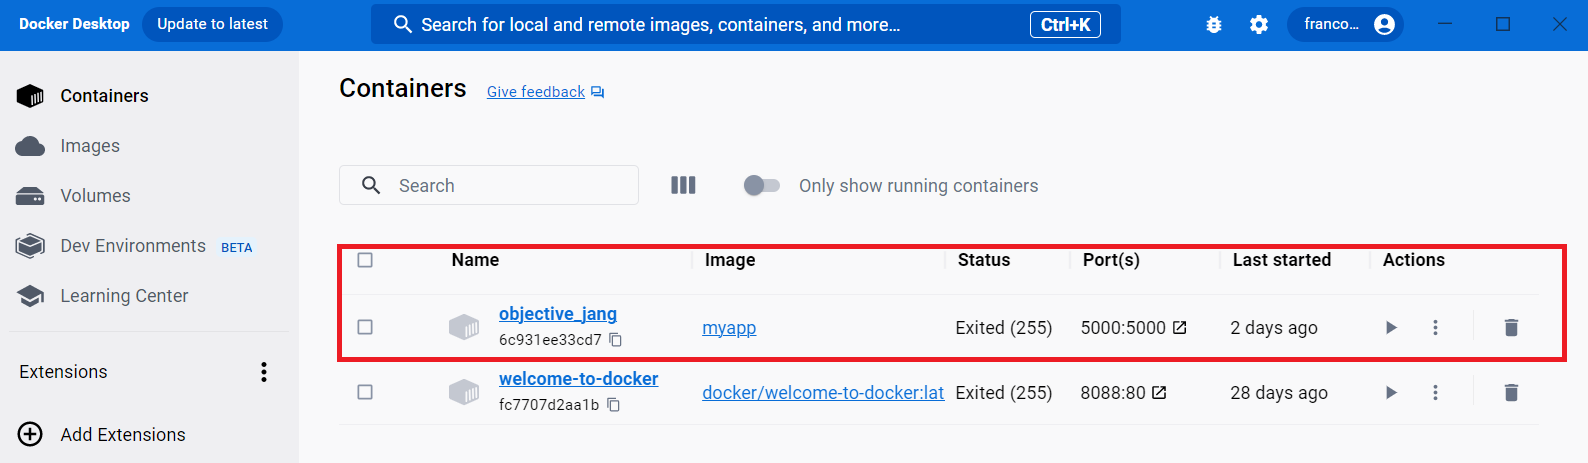

In [ ]:
#A continuación si quisieramso probar nuesta App utilizariamos los siguientes comandos. Aquí he tenido el problema de que no he conseguido visualizar correctamente mi app en la pagina Web, por tiempo no he conseguido averiguar el motivo pero aun así la he subido a Dcoker Hub:

docker run -p 5000:5000 myapp

#Y para visualizarlo en la web: http://localhost:5000/predict

In [ ]:
#Por último utilizo los siguientes comandos, el primero para etiquetar mi imagen con mi nombre de usuario y el repositorio en el que lo quiero guardar:

docker tag myapp francobos/pec2:latest

#Y finalmente utilizo el comando push para subir mi imagen:

docker push francobos/pec2:latest

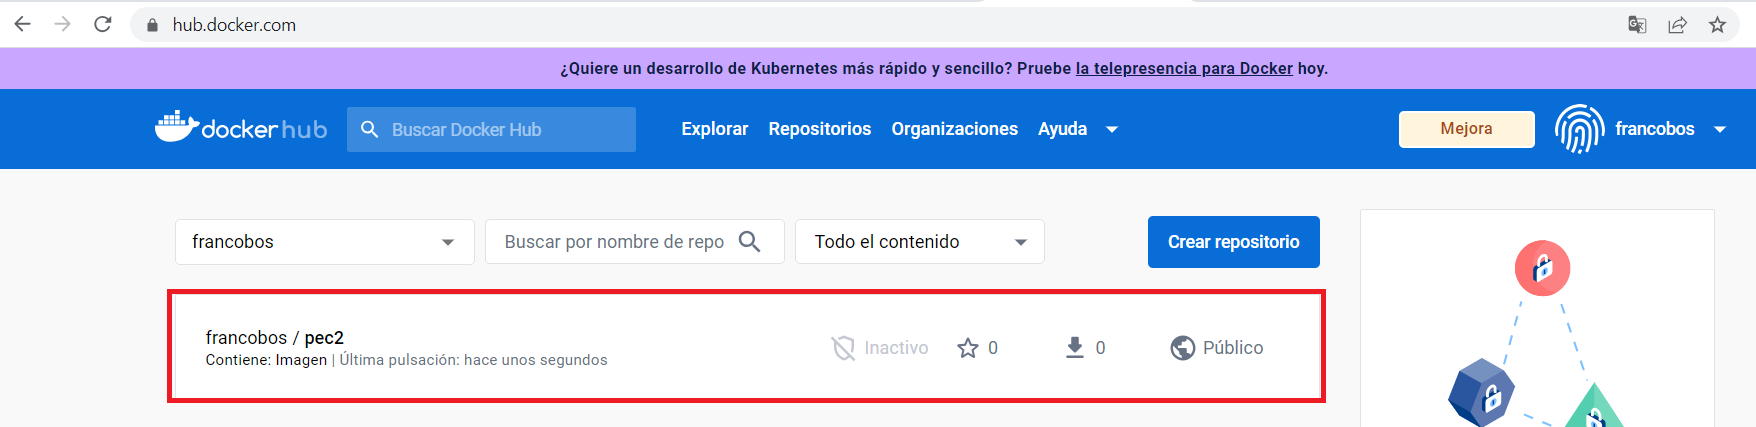

In [ ]:
#Finalmente dejo aquí mi comando pull para descargar la imagen:

docker pull francobos/pec2:latest

#Y el enlace a mi repositorio Git:

https://github.com/zicox13/titanic.git